## contents:
* [wrms implementation](#wrms-implementation)
* [weighting filter implementation](#weighting-filter-implementation)
* [data processing](#data-processing)

_reference paper is ISO 2631-1 1997_

In [2]:
from matplotlib import pyplot
import numpy
import pandas
import scipy.signal, scipy.integrate

In [3]:
def multipolymul(*args):
    """ Allow more than 2 polynomials to be multiplied using numpy.polymul
    
    :param arguments args: The polynomials to be multiplied
    :returns: An array of the resultant polynomial
    :rtype: numpy.ndarray
    """
    
    if (len(args) == 1):
        return args[0]
    else:
        return numpy.polymul(args[0], multipolymul(*args[1:]))

# wrms implementation
Equation 1 from page 6, "weighted r.m.s. acceleration"
$$
a_w = [\frac{1}{T}\int_{0}^{T} a_w^2(t)dt)]^{\frac{1}{2}}
\\ a_w = [\frac{1}{T}( \frac{1}{3}a_w^3(t) \mid_0^T )]^{\frac{1}{2}}
\\ a_w = [\frac{1}{3T}( a_w^3(T) - a_w^3(0) )]^{\frac{1}{2}}
$$

In [4]:
def wrms(weighted_accelerations, duration):
    """ Calculate weighted root-mean-square acceleration as per ISO 2631-1:1997(E)
    
    :param list weighted_accelerations: List of weighted accelerations
    :param float duration: The time over which the weighted accelerations appear
    :rtype: float
    """
    
    return (
        1/3*duration
        * (
            weighted_accelerations[-1]**3
            - weighted_accelerations[0]**3
        )
    )**(1/2)

def wrms_adxl_df(df, axis):
    """ Wrapper for wrms that takes a dataframe as input
    :param pandas.core.frame.DataFrame df: A dataframe produced by calling pandas.read_csv
    """
    return wrms(
        list(data["X"]),
        df.iloc[-1]["TIME"] - df.iloc[0]["TIME"]
    )

# weighting filter implementation
![screenshot](nbstatic/iso_2631-1-p18.png)
![screenshot](nbstatic/iso_2631-1-p19.png)
![screenshot](nbstatic/iso_2631-1-p20.png)

In [11]:
TRANSFER_PARAMS = pandas.read_csv("./nbstatic/iso_2631-1_transfer_params.csv")
TRANSFER_PARAMS.index = TRANSFER_PARAMS.pop("weighting")

def construct_filter(weighting):
    """ Construct the weighting function described in Annex A of ISO 2631-1 1997
    
    The type of weighting is one of the following (from section 6.4.1):
    * "k": "the z direction and for vertical recumbent direction (except head)"
    * "d": "the x and y directions and for horizontal recumbent direction"
    * "f": "related to motion sickness"
    * "c": "seat-back measurements"
    * "e": "measurement of rotational vibration"
    * "j": "measurement of vibration under the head of a recumbent person"
    
    :param str weighting: The type of weighting to be used
    :returns: A tuple containing the numerator and denominator coefficient vectors of the weighting function
    :rtype: tuple
    """

    (f_1, f_2, f_3, f_4, Q_4, f_5, Q_5, f_6, Q_6) = TRANSFER_PARAMS.loc[weighting]
    (w_1, w_2, w_3, w_4, w_5, w_6) = 2 * numpy.pi * numpy.array([f_1, f_2, f_3, f_4, f_5, f_6])
    
    numerators = []
    denominators = []

    # High pass band-limiting, H_h(p)
    # numerator and denominator were multiplied by p^2 to avoid negative exponents
    numerators.append([1, 0, 0])
    denominators.append([1, numpy.sqrt(2) * w_1, w_1**2])

    # Low pass band-limiting, H_l(p)
    numerators.append([1])
    denominators.append([1/w_2**2, numpy.sqrt(2)/w_2, 1])

    # Acceleration-velocity transition, H_t(p)
    if (weighting != "j"):
        numerators.append([1/w_3, 1])
        denominators.append([1/w_4**2, 1/(Q_4 * w_4), 1])

    # Upward step, H_s(p)
    if (not weighting in "cde"):
        numerators.append([1, w_5/Q_5, w_5**2])
        denominators.append([1, w_6/Q_6, w_6**2])

    return (multipolymul(*tuple(numerators)), multipolymul(*tuple(denominators)))

def H(p, weighting):
    """ Apply a weighting filter with of the given type to the input data
    
    How To apply a filter to a signal in python
    https://stackoverflow.com/a/13740532
    
    :param list p: Input data
    :param str weighting: Weighting type (see documentation of construct_filter)
    :returns: Filtered data
    :rtype: numpy.array
    """

    (numerator, denominator) = construct_filter(weighting)
    return scipy.signal.lfilter(numerator, denominator, p)

### sanity check against curves found in the ISO (page 11)

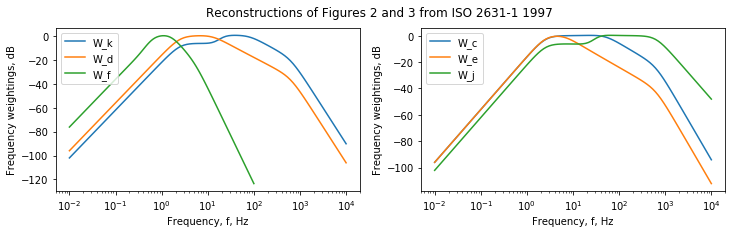

In [6]:
figure, axes = pyplot.subplots(1, 2, figsize = (12, 3))
weightings = [["k", "d", "f"], ["c", "e", "j"]]

for i in range(len(weightings)):
    for weighting in weightings[i]:
        axes[i].semilogx(
            *scipy.signal.bode(
                scipy.signal.lti(
                    *construct_filter(weighting)
                )
            )[:2],
            label = "W_%s" % weighting
        )
        axes[i].set_ylabel("Frequency weightings, dB")
        axes[i].set_xlabel("Frequency, f, Hz")
        axes[i].legend()

pyplot.suptitle("Reconstructions of Figures 2 and 3 from ISO 2631-1 1997")
pyplot.show()

![screenshot](nbstatic/iso-curves.png)

# data processing

from https://community.plm.automation.siemens.com/t5/Testing-Knowledge-Base/What-is-A-weighting/ta-p/357894:

![screenshot](nbstatic/siemens-dba.png)

In [7]:
# https://www.mathworks.com/matlabcentral/answers/319382-how-can-i-convert-acceleration-time-data-to-find-frequency#comment_419657

data = pandas.read_csv("./data/adxl345_1528079110.csv")
axis = "X"

accelerations = data[axis]
timestamps = data["TIME"]
rate = timestamps.diff().mean()

velocities = scipy.integrate.cumtrapz(accelerations, timestamps)
displacements = scipy.integrate.cumtrapz(velocities, timestamps[:-1])
(frequencies, times, spectrogram) = scipy.signal.spectrogram(displacements, rate)

weighted_frequencies = H(frequencies, "d")

In [8]:
data = pandas.read_csv("./data/adxl345_1528079110.csv")
duration = data.iloc[-1]["TIME"] - data.iloc[0]["TIME"]
weighted = H(data["X"], "d")
weighted = weighted[~numpy.isnan(weighted)]
wrms(weighted, duration)

inf

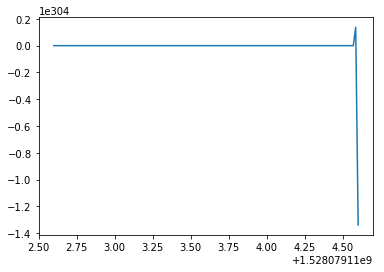

In [9]:
pyplot.plot(data["TIME"], H(data["X"], "d"))
pyplot.show()

In [10]:
H(data["X"], "d")

array([ 3.32387286e+06, -2.98653680e+09,  1.34159386e+12, ...,
                   nan,             nan,             nan])